# Mixture of Experts Experiments
### Fault characterization, prediction, and mitigation for LLM training and inference using MoE architectures

Dylan Everingham, TU Berlin Distributed and Operating Systems (DOS)

everingham@tu-berlin.de

02.02.2026

In [1]:
from experiments import *

/home/dylan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Set seeds
seed = 100
np.random.seed(seed);
torch.manual_seed(seed);

Total Trainable Params: 2989184


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch: 1, Train loss: 2.068, Train acc: 0.343, Val acc: 0.768, Val gen acc: 0.055 Epoch time = 22.264s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch: 2, Train loss: 0.248, Train acc: 0.911, Val acc: 0.971, Val gen acc: 0.672 Epoch time = 22.454s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch: 3, Train loss: 0.080, Train acc: 0.974, Val acc: 0.993, Val gen acc: 0.891 Epoch time = 22.567s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch: 4, Train loss: 0.052, Train acc: 0.984, Val acc: 0.997, Val gen acc: 0.953 Epoch time = 22.428s


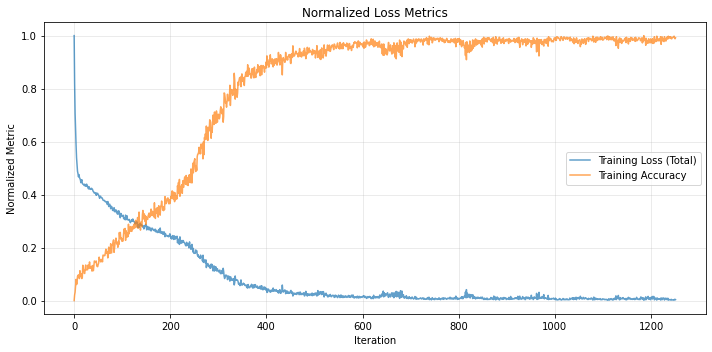

In [3]:
(model, tokenizer,
 args, history) = \
run_experiment_train(model_type=TransformerLM,
                     task='string_reverse',
                     enable_wandb=False)

#run_experiment_train_basic_decoderonly_text(enable_wandb=False)

In [12]:
start_context = "iamapalindrome"

output_text = generate_text(
    model=model,
    tokenizer=tokenizer,
    start_context=start_context,
    max_length=20
)

final_text = start_context + output_text

print("Final text:", final_text)

Final text: iamapalindrome[emordnilapamai\


In [5]:
test_generation_reverse(model, n_samples=10)

 20%|████████▊                                   | 2/10 [00:00<00:00, 19.83it/s]

For input:[ereebwtwddzgwpy\ Got output:[ypwgzddwtwbeere\Expected:[ypwgzddwtwbeere\ Correct!
For input:[dyafsbmipjnneujc\ Got output:[cjuennjpimbsfayd\Expected:[cjuennjpimbsfayd\ Correct!
For input:[jahvclnvmalpxathih\ Got output:[hihtaxplamvnlcvhaj\Expected:[hihtaxplamvnlcvhaj\ Correct!
For input:[gbojvaqxcr\ Got output:[rcxqavjobg\Expected:[rcxqavjobg\ Correct!


 50%|██████████████████████                      | 5/10 [00:00<00:00, 23.24it/s]

For input:[qwexaycxdulwzv\ Got output:[vzwludxcyaxewq\Expected:[vzwludxcyaxewq\ Correct!
For input:[iauwfksjaa\ Got output:[aajskfwuai\Expected:[aajskfwuai\ Correct!


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 24.11it/s]

For input:[pbhdfbpqqqj\ Got output:[jqqqpbfdhbp\Expected:[jqqqpbfdhbp\ Correct!
For input:[dptyczbttmdxzvzlry\ Got output:[yrlzvzxdmttbzcytpd\Expected:[yrlzvzxdmttbzcytpd\ Correct!
For input:[icsgeqdphsbzfr\ Got output:[rfzbshpdqegsci\Expected:[rfzbshpdqegsci\ Correct!
For input:[iiqojlguqkbjxnxr\ Got output:[rxnxjbkqugljoqii\Expected:[rxnxjbkqugljoqii\ Correct!


In [6]:
#run_experiment_inference(model_basic)